# Synthetic Flare Injection

- [Method and example](#Method-and-example)
- [Long Cadence](#Long-Cadence)

In [1]:
import os
import sys

from random import uniform, random

import numpy as np

from astropy.table import Table, Column
from astropy import units as u
from astropy.time import Time

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt

import arhap

sys.path.append('../src')

import injection

## Method and example



In [2]:
lc_info_table = Table.read("../data_tables/kepler_longcad_info.ecsv",format="ascii.ecsv")

In [3]:
# Adding distances to info table

galex_flare_stats  = Table.read("../data_tables/galex_flare_stats.ecsv", format="ascii.ecsv")

lc_info_table.add_column(Column(name="distance", dtype=float, length=len(lc_info_table)))
for row in lc_info_table:
    row["distance"] = galex_flare_stats[galex_flare_stats["KID"] == row["KID"]][0]["Dist"]

We use the model flare equations from [Davenport et al. 2014](https://iopscience.iop.org/article/10.1088/0004-637X/797/2/122/pdf):

- $F_{rise} = 1+1.941(±0.008)t_{1/2}−0.175(±0.032)t_{1/2}^2−2.246(±0.039)t_{1/2}^3−1.125(±0.016)t_{1/2}^4$, $-1 \le t_{1/2} \le 0$
- $F_{decay}=0.6890(±0.0008)e^{−1.600(±0.003)t_{1/2}}+0.3030(±0.0009)e^{−0.2783(±0.0007)t_{1/2}}$, $t_{1/2} \ge 0$

This is in relative flux ($\frac{(f-f_{qui})}{(f_{peak}-f_{qui})}$) and with time scaled to the FWHM $t_{1/2}$.
  
  
We want to start with the energy of a flare and figure out what the corresponding Kepler flux is.
This depends on the parameters of the synthetic flare ($t_{1/2}$, $f_{peak}$) and the distance to the star.

In [8]:
kid = lc_info_table[2]["KID"]
distance = lc_info_table[2]["distance"]*u.pc
lc_table = Table.read(lc_info_table[2]["path"])

In [9]:
t_12=5*u.min
flare_eng = 4*10**34*u.erg

In [10]:
f_peak = injection.params_to_peak_kepler_flux(distance, flare_eng, t_12)
f_peak

<Quantity 531.21645937 electron / s>

Once we've determined the peak flux in $e^-/s$ we can generate the flare flux across each light curve bin and add the additional flux to the light curve.

In [18]:
t_peak = Time(2455760.2,format="jd", scale='tdb')
orig_fluxes = Column(lc_table["flux"], copy=True)

In [19]:
exptime_12 = arhap.Kepler_lc_exptime/2  # 1/2 Kepler long cadence time bin
bin_starts = lc_table["time"] - exptime_12

In [20]:
integrated_flux = injection.make_fluence_function(f_peak, t_12, t_peak)
injection.inject_flare(lc_table, integrated_flux, [t_peak-t_12,t_peak+100*t_12])

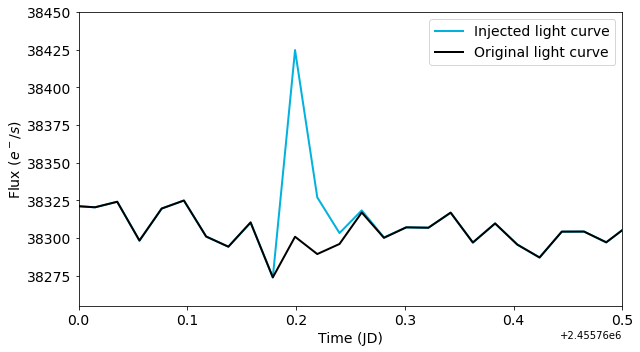

In [44]:
f, ax = plt.subplots(figsize=(9, 5))
ax.tick_params(axis='both', which='major', labelsize=14)

ax.plot(lc_table["time"].jd,lc_table['flux'], c="#00b2dd", label="Injected light curve", lw=2)
ax.plot(lc_table["time"].jd,orig_fluxes, c='k', label="Original light curve", lw=2)

ax.set_xlim(2455760,2455760.5)
ax.set_ylim(38255,38450)

ax.legend(fontsize=14)

ax.set_ylabel("Flux ($e^-/s$)", fontsize=14)
ax.set_xlabel("Time (JD)", fontsize=14)

f.tight_layout()
plt.show()

## Long Cadence

These are the steps we take
- Sample the Energy in log space.
- GALEX flares run from about $2(10^{32})$ erg to $9(10^{37})$ erg.
- From Osten & Wolk 2015: $\frac{E_{kepler}}{E_{bol}} = 0.16$
- So we expect the Kepler energy to range from ~$3\times10^{31}$ to $1.5\times10^{37}$ ergs, although we do not restrict the energy at the top.
- We'll sample flares with t_12 in the range 30 sec to 1 hour.

**Note:** This step takes a LONG TIME (8-12 hours on my laptop)

In [46]:
lc_info_table.add_column(Column(name="injected_path", dtype='U256', length=len(lc_info_table)))
lc_info_table.add_column(Column(name="synth_flare_path", dtype='U256', length=len(lc_info_table)))

In [50]:
mkdir ../light_curves/kepler_lc_injected

In [55]:
for lc_row in lc_info_table:
    
    # Skip rows we've already done
    if lc_row["injected_path"]:
        continue
        
    injected_path = lc_row["path"].replace("kepler_lc","kepler_lc_injected")
    info_path = injected_path.replace("_lc.","_synths.")
    
    # Getting the info we need
    kid = lc_row["KID"]
    distance = lc_row["distance"]*u.pc
    lc_table = Table.read(lc_row["path"])
    
    # Making and injecting the synthetic flares
    flare_info = {'f_peak':[], 't_12':[], 't_peak':[], 'flare_eng':[]}
    for partition in np.unique(lc_table["partition"]):
        
        num_flares = int(len(lc_table[lc_table["partition"]==partition])*0.2)
        t_min = lc_table["time"][lc_table["partition"]==partition][1]
        t_max = lc_table["time"][lc_table["partition"]==partition][-1]
    
        t_12_list = np.array([uniform(30,3600) for i in range(num_flares)])*u.second
        flare_eng_list = np.array([injection.inverse_cdf(random()) for x in range(num_flares)])*u.erg
        
        f_peak_list = injection.params_to_peak_kepler_flux(distance, flare_eng_list, t_12_list)
        t_peak_list = Time(np.array([uniform(t_min,t_max) for x in range(num_flares)]))
    
        for t_12, f_peak, t_peak,  flare_eng in zip(t_12_list, f_peak_list, t_peak_list, flare_eng_list):           
            
            flare_func = injection.make_fluence_function(f_peak, t_12, t_peak)
            injection.inject_flare(lc_table, flare_func, [t_peak-t_12,t_peak+100*t_12])
            
            flare_info['f_peak'].append(f_peak.value)
            flare_info['t_12'].append(t_12.to(u.min).value)
            flare_info['t_peak'].append(t_peak)
            flare_info['flare_eng'].append(flare_eng.value)
    
    # Saving out the file and recording the path
    lc_table.write(injected_path, format="ascii.ecsv", overwrite=True)
    lc_row["injected_path"] = injected_path
    
    # Saving the flare info
    info_table = Table(flare_info)
    info_table["t_peak"] = Time(info_table["t_peak"])
    info_table.write(info_path, format="ascii.ecsv", overwrite=True)
    lc_row["synth_flare_path"] = info_path

In [58]:
lc_info_table.write("../data_tables/kepler_longcad_info.ecsv", format="ascii.ecsv", overwrite=True)